In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Conv1D

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
df_distinct_stacks['listStackTrace'] = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.split('\n'))
corpus = df_distinct_stacks['listStackTrace'].tolist()
frames = pd.Series(list(set([elt for l in corpus for elt in l])))
df_frames = pd.DataFrame()
df_frames['frame'] = pd.get_dummies(frames).T.reset_index().rename(columns={'index': 'frame'})['frame']
df_frames['embedding'] = pd.get_dummies(frames).T.reset_index().apply(lambda x : x[1:].values, axis = 1)
df_distinct_stacks['rankFrames'] = df_distinct_stacks['listStackTrace'].apply(lambda x : index_frame(x, df_frames))

In [7]:
df_levenshtein = pd.DataFrame()
df_levenshtein['Levensh'] = df_measures['Levensh']
df_levenshtein['stack1'] = df_levenshtein.apply(lambda x : assign_stacks(rowIndex(x), df_distinct_stacks)[0], axis = 1)
df_levenshtein['stack2'] = df_levenshtein.apply(lambda x : assign_stacks(rowIndex(x), df_distinct_stacks)[1], axis = 1)

In [8]:
embeddings = 1 * np.random.randn(df_frames.shape[0] + 1, df_frames['embedding'][0].shape[0])
embeddings[0] = 0
embeddings[1:] = np.vstack(df_frames['embedding'].tolist())
embeddings.shape

(2246, 2245)

In [9]:
X = df_levenshtein[['stack1','stack2']]
Y = df_levenshtein['Levensh']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.2)

max_length = df_distinct_stacks['listStackTrace'].apply(lambda x : len(x)).max()
X_train = padding(X_train, max_length)
X_validation = padding(X_validation, max_length)

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

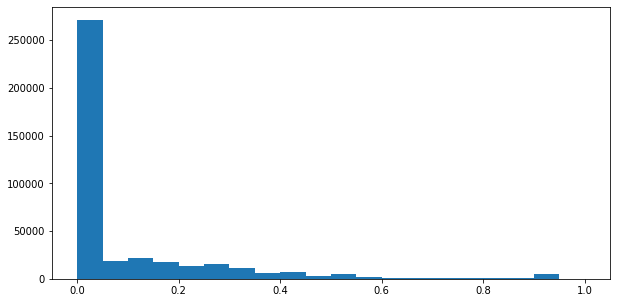

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

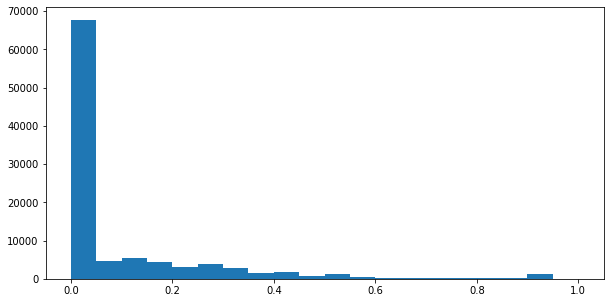

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

<div>
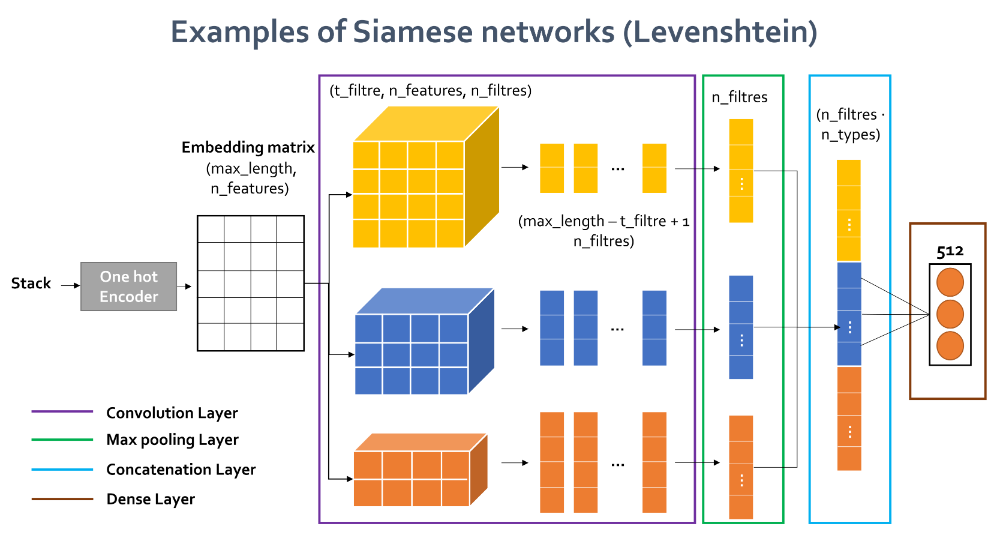
<div>

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 16

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

1024

## 2.1. Feature learning phase

In [17]:
input_tensor = Input(shape = (max_length,))
input_layer = (Embedding(len(embeddings), df_frames.shape[0], weights=[embeddings], input_shape=(max_length,), trainable=False))(input_tensor)
submodels = []
for kw in (3,4) :
    conv_layer = Conv1D(1024, kw, activation='tanh')(input_layer)
    maxpool_layer = GlobalMaxPooling1D()(conv_layer)
    submodels.append(maxpool_layer)
conc_layer = concatenate(submodels, axis=1)
dense_layer = Dense(size_hash_vector, activation = 'tanh')(conc_layer)
x = Sequential()
x.add(Model(inputs = input_tensor, outputs = dense_layer))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (max_length,)
model = siamese_model(shared_model, input_shape, b, m, is_sparse = False, print_summary = False)

## 2.3. Model training 

In [ ]:
siamese_model = train_siamese_model(model, X_train, X_validation, Y_train, Y_validation, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 446s 557ms/step - loss: 0.0207 - ham_dist_loss: 0.0209 - prod_vec_loss: 0.0356 - prod_vec_1_loss: 0.0352 - sum_vec_loss: 3.1074e-04 - sum_vec_1_loss: 3.5735e-04 - ham_dist_rmse: 0.1446 - ham_dist_mae: 0.0563 - val_loss: 0.0019 - val_ham_dist_loss: 0.0018 - val_prod_vec_loss: 0.0048 - val_prod_vec_1_loss: 0.0045 - val_sum_vec_loss: 1.5870e-04 - val_sum_vec_1_loss: 1.6046e-04 - val_ham_dist_rmse: 0.0426 - val_ham_dist_mae: 0.0204
Epoch 2/20
781/781 [==============================] - 434s 556ms/step - loss: 0.0012 - ham_dist_loss: 0.0012 - prod_vec_loss: 0.0035 - prod_vec_1_loss: 0.0032 - sum_vec_loss: 1.1254e-04 - sum_vec_1_loss: 1.0323e-04 - ham_dist_rmse: 0.0349 - ham_dist_mae: 0.0166 - val_loss: 0.0010 - val_ham_dist_loss: 0.0010 - val_prod_vec_loss: 0.0025 - val_prod_vec_1_loss: 0.0024 - val_sum_vec_loss: 1.0255e-04 - val_sum_vec_1_loss: 8.4954e-05 - val_ham_dist_rmse: 0.0320 - val_ham_dist_mae: 0.0146
Epoch 3/20
781/781 [========

# 3. Model Evaluation

In [40]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{DeepLSH}$

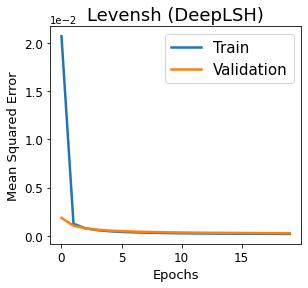

In [41]:
plt.rcParams["figure.figsize"] = (4.5,4)
plt.plot(siamese_model.history['loss'], linewidth = 2.5)
plt.plot(siamese_model.history['val_loss'], linewidth = 2.5)
plt.title('Levensh (DeepLSH)', fontsize = 18)
plt.ylabel('Mean Squared Error', fontsize = 13)
plt.xlabel('Epochs', fontsize = 13)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))
plt.savefig('Results/DeepLSH/loss-MSE.png', bbox_inches='tight')
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of LSH preserving loss

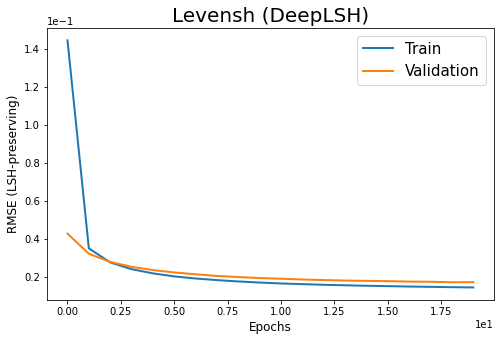

In [42]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Levensh (DeepLSH)', fontsize = 20)
plt.ylabel('RMSE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

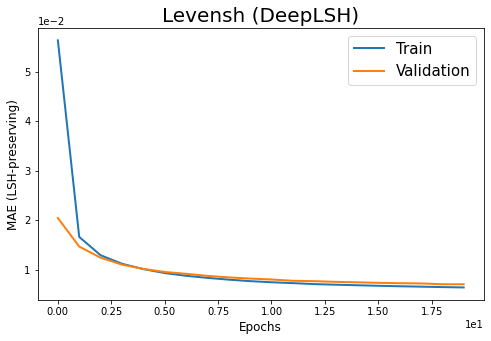

In [43]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Levensh (DeepLSH)', fontsize = 20)
plt.ylabel('MAE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [44]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [45]:
np.around(predictions[0][:50],3) 

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.032, 0.   , 0.162,
       0.   , 0.17 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.128, 0.179,
       0.   , 0.084, 0.499, 0.009, 0.233, 0.471, 0.003, 0.016, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.329, 0.029, 0.   , 0.   , 0.   ,
       0.   , 0.029, 0.131, 0.   , 0.   , 0.   , 0.395, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.049, 0.016], dtype=float32)

In [46]:
np.around(Y_validation[:50],3) 

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.158,
       0.   , 0.227, 0.   , 0.   , 0.   , 0.   , 0.   , 0.136, 0.118,
       0.   , 0.095, 0.5  , 0.   , 0.222, 0.4  , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.35 , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.125, 0.   , 0.   , 0.   , 0.4  , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.043, 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

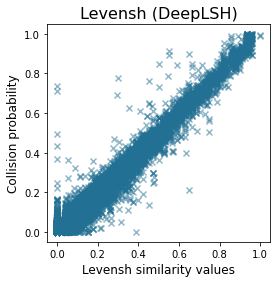

In [47]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Levensh (DeepLSH)', fontsize = 16)
plt.xlabel("Levensh similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/DeepLSH/Levensh-correlation', bbox_inches='tight')
plt.show()

In [48]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.847338382994975

In [49]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.7421557169115531

## 3.3. Approximate Hamming Evaluation

In [50]:
output_layer = 0
model.layers[output_layer]

In [51]:
intermediate_model = intermediate_model_trained(shared_model, output_layer, True, input_tensor)

In [52]:
intermediate_model.save('Models/model-deep-lsh.model')

INFO:tensorflow:Assets written to: Models/model-deep-lsh.model/assets


In [ ]:
#intermediate_model = keras.models.load_model('Models/model-deep-lsh.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [53]:
intermediate_model.predict(padding(X.iloc[[11]], max_length)['stack_1'])[0][:32]

array([-0.99930245,  1.        , -0.99999833, -1.        , -1.        ,
       -0.9992887 , -0.99942774, -1.        ,  0.9992537 ,  1.        ,
        0.99935   , -0.9999913 , -1.        , -0.9999644 ,  0.9993916 ,
        0.99964243,  0.9999104 ,  0.9988533 , -1.        , -0.99997795,
       -0.99876684,  1.        , -1.        ,  0.99999684,  0.9989056 ,
       -0.99891794, -0.9996947 , -0.99999803,  0.99974984, -0.9993663 ,
       -0.99998075,  1.        ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [54]:
hash_vectors = intermediate_model.predict(pad_sequences(df_distinct_stacks['rankFrames'], padding = 'post', truncating = 'post', maxlen = 29)) 

In [55]:
np.mean(np.abs(hash_vectors))

0.9941039

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [56]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.3052900390625

### 3.3.4. Comparison between approximate hamming and real hamming

In [57]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

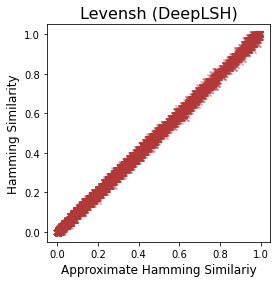

In [58]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Levensh (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Levensh-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [59]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [60]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)


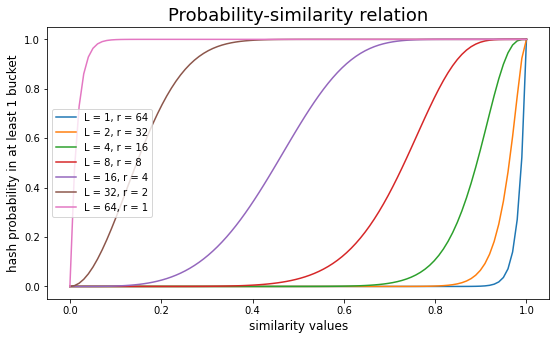

In [61]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [64]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Levensh', trace = False)

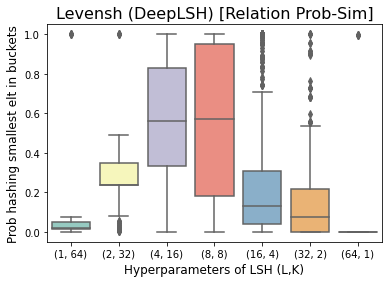

In [65]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Levensh (DeepLSH) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/DeepLSH/Levensh-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [63]:
'Exemple, L = K = 8'
L, K = params[2]
L, K

(4, 16)

In [66]:
df_probLSH.mean()['(4, 16)']

0.5479957772968685

In [67]:
df_probLSH.median()['(4, 16)']

0.5594587696299558

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [68]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [69]:
with open('Hash-Tables/hash_tables_deeplsh.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [72]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

349

In [73]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{82, 117, 314, 349, 406, 550, 684, 748, 769, 775, 865}

In [74]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [75]:
near_duplicates_sim = df_measures['Levensh'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

288344    0.956522
288350    0.956522
288259    0.956522
288323    0.956522
287981    0.956522
264579    0.956522
288440    0.913043
288125    0.913043
110328    0.913043
78863     0.869565
Name: Levensh, dtype: float64

In [76]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Levensh', n_stacks, n_duplicate_pairs)
set_real_nns

{11, 117, 314, 406, 550, 684, 748, 769, 775, 865}

In [77]:
real_nns_sim[:n_duplicate_pairs]

264579    0.956522
288350    0.956522
287981    0.956522
288344    0.956522
288323    0.956522
288259    0.956522
288440    0.913043
110328    0.913043
288125    0.913043
11271     0.913043
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [79]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

0.883

In [ ]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

-----------------------------------------------------------------

In [80]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

0.9173333333333329

In [ ]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

-----------------------------------------------------------------

In [81]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

0.9363999999999998

In [ ]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))}$

In [78]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

0.9916666666666666

In [82]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Levensh', trace = False)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    0.990842
(2, 32)    0.979285
(4, 16)    0.966719
(8, 8)     0.947751
(16, 4)    0.889116
(32, 2)    0.950990
(64, 1)    0.998500
dtype: float64

In [ ]:
df_knns.mean(skipna = True, axis = 0)['(8, 8)']

### 4.4.3. Recall w.r.t. LSH

In [83]:
df_recall = recall_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Levensh', trace = False)
df_recall.mean(skipna = True)

(1, 64)    0.750000
(2, 32)    1.000000
(4, 16)    0.833483
(8, 8)     0.882088
(16, 4)    0.794238
(32, 2)    0.860079
(64, 1)    0.979226
dtype: float64

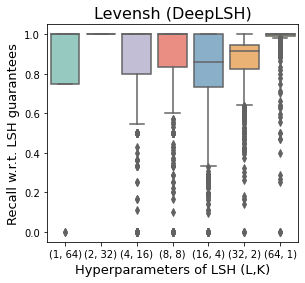

In [84]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Recall w.r.t. LSH guarantees", fontsize = 13)
plt.title('Levensh (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Recall-LSH', bbox_inches='tight')
plt.show()

### 4.4.4. Precison w.r.t. LSH

In [85]:
df_precision = precision_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Levensh', trace = False)
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.032967
(2, 32)    0.018817
(4, 16)    0.706497
(8, 8)     0.775874
(16, 4)    0.733226
(32, 2)    0.809285
(64, 1)    0.818428
dtype: float64

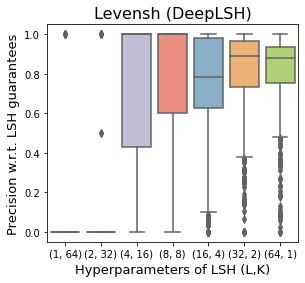

In [86]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 13)
plt.title('Levensh (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/precision-LSH', bbox_inches='tight')
plt.show()

### 4.4.5. Fscore w.r.t. LSH

In [87]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.032609
(2, 32)    0.019713
(4, 16)    0.676223
(8, 8)     0.765640
(16, 4)    0.716491
(32, 2)    0.813920
(64, 1)    0.882275
dtype: float64

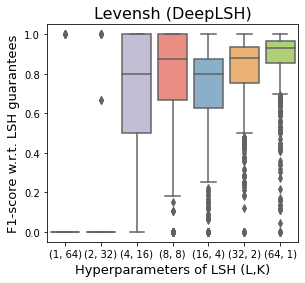

In [88]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 13)
plt.title('Levensh (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/fscore-LSH', bbox_inches='tight')
plt.show()